<a href="https://colab.research.google.com/github/palakagl/AI-in-Finance/blob/main/Stock_Price_Prediction_LSTM_with_Multiple_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install yfinance --upgrade --no-cache-dir

In [27]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os


import math
import yfinance as yf

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Get Stock Price, S&P Index, Nasdaq Index price from Yahoo Finance

In [29]:
df_stock = web.DataReader('TSLA', 'yahoo', start='2012-01-01', end='2022-03-20')

df_stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500.0,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500.0,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500.0,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500.0,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000.0,5.450000
...,...,...,...,...,...,...
2022-03-14,800.700012,756.039978,780.609985,766.369995,23717400.0,766.369995
2022-03-15,805.570007,756.570007,775.270020,801.890015,22280400.0,801.890015
2022-03-16,842.000000,802.260010,809.000000,840.229980,28009600.0,840.229980


Text(0, 0.5, 'Stock Price ($)')

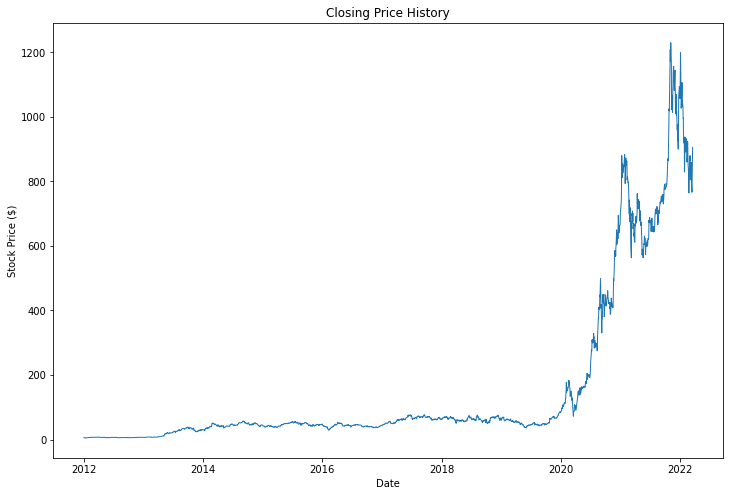

In [30]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df_stock['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [31]:
df_snp = web.DataReader('^GSPC', 'yahoo', start='2012-01-01', end='2022-03-20')

df_snp

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,1284.619995,1258.859985,1258.859985,1277.060059,3943710000,1277.060059
2012-01-04,1278.729980,1268.099976,1277.030029,1277.300049,3592580000,1277.300049
2012-01-05,1283.050049,1265.260010,1277.300049,1281.060059,4315950000,1281.060059
2012-01-06,1281.839966,1273.339966,1280.930054,1277.810059,3656830000,1277.810059
2012-01-09,1281.989990,1274.550049,1277.829956,1280.699951,3371600000,1280.699951
...,...,...,...,...,...,...
2022-03-14,4247.569824,4161.720215,4202.750000,4173.109863,4757600000,4173.109863
2022-03-15,4271.049805,4187.899902,4188.819824,4262.450195,4331170000,4262.450195
2022-03-16,4358.899902,4251.990234,4288.140137,4357.859863,5002240000,4357.859863


Text(0, 0.5, 'Stock Price ($)')

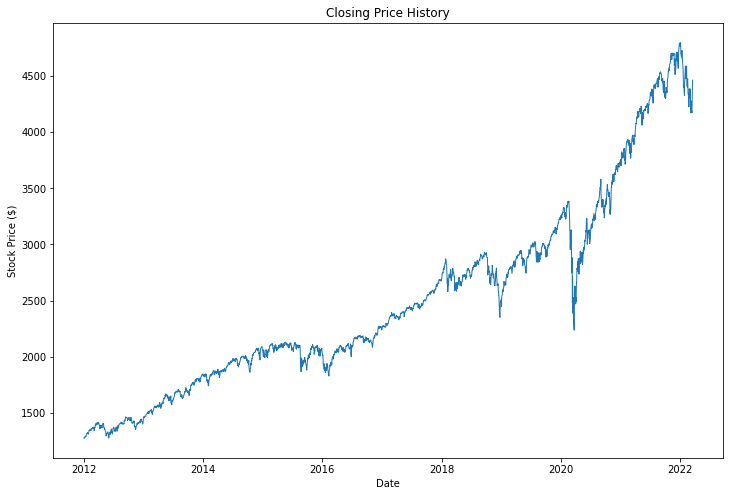

In [32]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df_snp['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [33]:
df_nasdaq = web.DataReader('^IXIC', 'yahoo', start='2012-01-01', end='2022-03-20')

df_nasdaq

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,2665.899902,2641.979980,2657.389893,2648.719971,1636850000,2648.719971
2012-01-04,2653.179932,2627.229980,2639.899902,2648.360107,1670530000,2648.360107
2012-01-05,2673.560059,2631.229980,2642.570068,2669.860107,1836410000,2669.860107
2012-01-06,2682.120117,2658.830078,2671.169922,2674.219971,1683090000,2674.219971
2012-01-09,2683.780029,2662.959961,2682.979980,2676.560059,1768080000,2676.560059
...,...,...,...,...,...,...
2022-03-14,12918.009766,12555.349609,12795.120117,12581.219727,5853360000,12581.219727
2022-03-15,12973.879883,12616.589844,12685.230469,12948.620117,5414590000,12948.620117
2022-03-16,13440.120117,12992.200195,13119.370117,13436.549805,6498110000,13436.549805


Text(0, 0.5, 'Stock Price ($)')

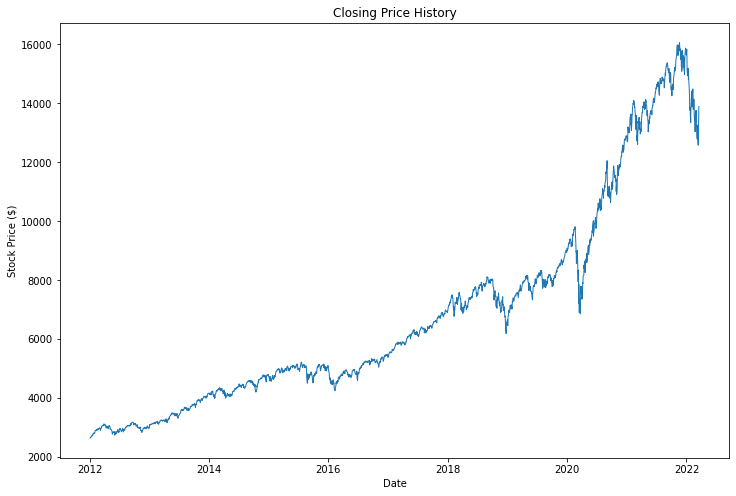

In [34]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df_nasdaq['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [43]:
df['Close_Stock'] = df_stock.filter(['Close'])
#df = df.drop('Close', axis=1)
df['CLose_S&P'] = df_snp.filter(['Close'])
df['CLose_Nasdaq'] = df_nasdaq.filter(['Close'])
df

,Close_Stock,CLose_S&P,CLose_Nasdaq
Date,,,
2012-01-03,5.616000,1277.060059,2648.719971
2012-01-04,5.542000,1277.300049,2648.360107
2012-01-05,5.424000,1281.060059,2669.860107
2012-01-06,5.382000,1277.810059,2674.219971
2012-01-09,5.450000,1280.699951,2676.560059
...,...,...,...
2022-03-14,766.369995,4173.109863,12581.219727
2022-03-15,801.890015,4262.450195,12948.620117
2022-03-16,840.229980,4357.859863,13436.549805


In [46]:
df.shape[0]

2570

Transform the Data

In [47]:
X0=[]
X1=[]
X2=[]
y=[]

look_back = 60

for i in range (0, df.shape[0]-look_back):
    X0.append(df.iloc[i:i + look_back, 0])
    X1.append(df.iloc[i:i + look_back, 1])
    X2.append(df.iloc[i:i + look_back, 2])
    y.append(df.iloc[i + look_back, 0])


In [48]:
type(X2)

list

In [49]:
df.head(5)

,Close_Stock,CLose_S&P,CLose_Nasdaq
Date,,,
2012-01-03,5.616,1277.060059,2648.719971
2012-01-04,5.542,1277.300049,2648.360107
2012-01-05,5.424,1281.060059,2669.860107
2012-01-06,5.382,1277.810059,2674.219971
2012-01-09,5.450,1280.699951,2676.560059


In [50]:
X0, X1, X2, y = np.array(X0), np.array(X1), np.array(X2), np.array(y)

In [51]:
X1.shape

(2510, 60)

In [52]:
y.shape

(2510,)

In [53]:
y=np.reshape(y,(len(y),-1))

In [54]:
y.shape

(2510, 1)

In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
X0 = scaler.fit_transform(X0)
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
y = scaler.fit_transform(y)

In [58]:
X=np.stack((X0,X1,X2), axis=2)
X

array([[[8.63425414e-04, 0.00000000e+00, 2.68372828e-05],
        [8.03034313e-04, 0.00000000e+00, 0.00000000e+00],
        [7.06735432e-04, 9.42580879e-04, 0.00000000e+00],
        ...,
        [1.84536508e-03, 3.93546065e-02, 2.81811572e-02],
        [1.93355050e-03, 3.82206097e-02, 2.80143670e-02],
        [1.91885319e-03, 3.62368266e-02, 2.68580798e-02]],

       [[8.03034313e-04, 6.98669670e-05, 0.00000000e+00],
        [7.06735432e-04, 1.09470635e-03, 1.60339110e-03],
        [6.72459717e-04, 0.00000000e+00, 3.25664771e-04],
        ...,
        [1.93355050e-03, 3.82206097e-02, 2.80143670e-02],
        [1.91885319e-03, 3.62368266e-02, 2.68580798e-02],
        [1.83393367e-03, 3.55945084e-02, 2.61368265e-02]],

       [[7.06735432e-04, 1.16449683e-03, 1.60339110e-03],
        [6.72459717e-04, 1.48486564e-04, 1.92853370e-03],
        [7.27953842e-04, 8.38140765e-04, 5.00460203e-04],
        ...,
        [1.91885319e-03, 3.62368266e-02, 2.68580798e-02],
        [1.83393367e-03, 3.55

In [59]:
X.shape

(2510, 60, 3)

In [61]:
X_train, X_test = X[:-514], X[-514:]
y_train, y_test = y[:-514], y[-514:]
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1996, 60, 3)

In [63]:
model = Sequential()
# set return requesnce = true, if we are going to have another LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [67]:
filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

In [68]:
optimizers.SGD(momentum=0.9)
model.compile(optimizer='SGD', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=10, callbacks=callbacks, batch_size=16)

Epoch 1/10
100/100 [==============================] - 11s 69ms/step - loss: 0.0099 - mae: 0.0754 - val_loss: 0.0415 - val_mae: 0.1979
Epoch 2/10
100/100 [==============================] - 6s 55ms/step - loss: 0.0050 - mae: 0.0556 - val_loss: 0.0306 - val_mae: 0.1690
Epoch 3/10
100/100 [==============================] - 6s 55ms/step - loss: 0.0034 - mae: 0.0447 - val_loss: 0.0231 - val_mae: 0.1461
Epoch 4/10
100/100 [==============================] - 7s 75ms/step - loss: 0.0018 - mae: 0.0310 - val_loss: 0.0153 - val_mae: 0.1169
Epoch 5/10
100/100 [==============================] - 6s 59ms/step - loss: 9.9490e-04 - mae: 0.0230 - val_loss: 0.0113 - val_mae: 0.0990
Epoch 6/10
100/100 [==============================] - 6s 61ms/step - loss: 5.9326e-04 - mae: 0.0175 - val_loss: 0.0081 - val_mae: 0.0818
Epoch 7/10
100/100 [==============================] - 6s 59ms/step - loss: 3.7221e-04 - mae: 0.0138 - val_loss: 0.0064 - val_mae: 0.0714
Epoch 8/10
100/100 [==============================] - 6s

In [69]:
MSE, MAE = model.evaluate(X_test, y_test)
print(MSE, MAE)

17/17 [==============================] - 1s 19ms/step - loss: 0.1440 - mae: 0.3501
0.14397549629211426 0.3501459062099457


In [70]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

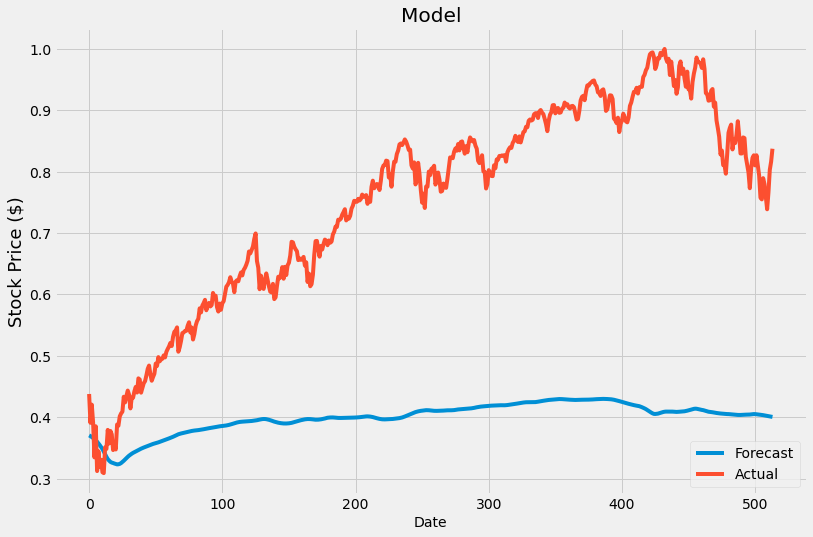

In [72]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Stock Price ($)', fontsize=18)
plt.plot(predictions)
plt.plot(scaler.inverse_transform(y_test))
plt.legend(['Forecast', 'Actual'],loc='lower right')
plt.show()